# Previsão de Séries Temporais para ampliar a visibilidade Logística nas Operações da ArcelorMittal

#### Código Fonte referente ao artigo de mesmo título submetido para publicação no ENEGEP 2020 - Encontro Nacional de Engenharia de Produção - http://portal.abepro.org.br/enegep/2020/

#### Autor: Marco Antônio Aburachid Tavares (ArcelorMittal Brasil) - marco.tavares@arcelormittal.com.br

---
# Conteúdo (Content)

- **1) Introdução e definição do Problema**
- **2) Dataset e definições de desenvolvimento do Modelo e Avaliação** 
    - 2.1) Dataset
    - 2.2) Visualizações iniciais
    - 2.3) Critérios de avaliação
- **4) Modelos: Agendamento e Técnicas de Previsão em Séries Temporais**
    - 4.1) Sistema de Agendamento - 1 dia
    - 4.2) Sistema de Agendamento - 2 dias
    - 4.3) Método - Naive
    - 4.4) Suavização Expoencial
    - 4.5) SARIMA
    - 4.6) Long Short Term Memory - LSTM
- **5) Execução em lote** 

- **6) Análise dos Resultados e Conclusões** 

---
# 1) Introdução e definição do Problema

A ArcelorMittal Brasil recebe semanalmente milhares de caminhões em suas plantas (mineração, fazendas, usinas, fábricas e distribuição). Ter uma previsão confiável de quantos veículos poderão chegar em um dado horizonte de tempo é fator crítico para viabilizar a eficiência da operação logística, permitindo alocar recursos de forma adequada (pessoas, máquinas e equipamentos), evitar custos não previstos (diárias, horas extras) e melhorar a satisfação do público envolvido, seja interno (equipes de portaria, de produção e funcionários em geral) ou externo (motoristas, fornecedores e comunidade local).

Para tratar esse problema foi desenvolvido um Sistema de Agendamento onde transportadoras agendam os veículos com base em uma data/hora prevista para chegada. A partir do Agendamento a Logística da planta industrial passa a ter visibilidade da quantidade de veículos prevista por perfil de operação (expedição ou recebimento de matéria-prima). Apesar das vantagens proporcionadas pelo sistema, a principal dificuldade é que a previsão da chegada dos veículos ocorre em um horizonte bastante curto (entre 1 a 3 dias).

O presente artigo é baseado em uma pesquisa interna para validar a hipótese de que utilizar técnicas de previsão de séries temporais podem ampliar a visibilidade proporcionada pelo sistema, considerando horizontes mais amplos e menor erro de previsão.

Apesar das diferenças entre os modelos (detalhadas na sessão 3.1) o estudo comprovou que 2 das 4 técnicas proporcionam um erro de previsão menor em um horizonte de 14 dias do que o sistema para o horizonte de 1 dia.

---
# 2) Dataset e definições de desenvolvimento do Modelo e Avaliação

## 2.1) Dataset

In [1]:
# Importar bibliotecas principais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Definir configurações gerais
pd.set_option("display.max_rows", 2200)

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importar os dados e definir o formato de Data para o campo "Data"e Float para os campos numéricos, já que determinadas tarefas nos modelos não permitem campos de Inteiro
dados = pd.read_excel("time_series_data.xlsx", parse_dates=['Data'], convert_float=False)

In [3]:
dados.head()

,Planta,Data,Recebidos,Agendados (01 dia antes),Agendados (02 dias antes)
0,Planta_01,2019-01-01,0.0,0.0,0.0
1,Planta_01,2019-01-02,133.0,14.0,14.0
2,Planta_01,2019-01-03,97.0,61.0,4.0
3,Planta_01,2019-01-04,106.0,40.0,5.0
4,Planta_01,2019-01-05,38.0,30.0,4.0


In [4]:
dados.shape

(1825, 5)

In [5]:
dados["Planta"].value_counts()

Planta_03    365
Planta_05    365
Planta_04    365
Planta_01    365
Planta_02    365
Name: Planta, dtype: int64

In [6]:
dados.dtypes

Planta                               object
Data                         datetime64[ns]
Recebidos                           float64
Agendados (01 dia antes)            float64
Agendados (02 dias antes)           float64
dtype: object

O dataset foi criado com os dados obtidos no próprio Sistema de Agendamento e é composto das seguintes informações:

- Planta: Corresponde a uma das 5 plantas industrias onde os dados foram obtidos.
- Data: Data de referência dos registros e vai do dia 01/01/2019 a 31/12/2019.
- Recebidos: Quantidade de veículos recebidos 
- Agendados (01 dia antes): Quantidade de veículos agendados para a data de referência com 01 dia de antecedência
- Agendados (02 dias antes): Quantidade de veículos agendados para a data de referência com 02 dias de antecedência


No dia 05/01/2019, na planta 01 foram recebidos 38 veículos enquanto 30 foram agendados com um dia de antecedência e desses 30 apenas 4 foram agendados com 2 dias de antecedência.

In [7]:
# Dividir o dataset em 5, sendo um para cada planta, criando uma cópia e resetando o índice
df_p01 = dados[(dados["Planta"] == "Planta_01")].copy().reset_index(drop=True)
df_p02 = dados[(dados["Planta"] == "Planta_02")].copy().reset_index(drop=True)
df_p03 = dados[(dados["Planta"] == "Planta_03")].copy().reset_index(drop=True)
df_p04 = dados[(dados["Planta"] == "Planta_04")].copy().reset_index(drop=True)
df_p05 = dados[(dados["Planta"] == "Planta_05")].copy().reset_index(drop=True)

## 2.2) Visualizações iniciais

In [8]:
dados['Recebidos'].sum()

120871.0

In [9]:
dados.groupby(['Planta'])['Recebidos'].sum()

Planta
Planta_01    30635.0
Planta_02    38852.0
Planta_03    13532.0
Planta_04    31942.0
Planta_05     5910.0
Name: Recebidos, dtype: float64

Conforme citado na introdução os dados utilizados são de uma pequena amostra da operação logística referente a um escopo específico de matérias primas e plantas, que no ano de 2019 contou com o recebimento de 120.871 veículos.

Das 05 plancas, a Planta 02 foi a que recebeu mais veículos seguida pelas plantas 4, 1, 3 e 5.

In [10]:
dados.groupby(['Planta'])['Recebidos'].describe()

,count,mean,std,min,25%,50%,75%,max
Planta,,,,,,,,
Planta_01,365.0,83.931507,54.307005,0.0,48.0,86.0,116.0,322.0
Planta_02,365.0,106.443836,58.325020,0.0,74.0,113.0,150.0,235.0
Planta_03,365.0,37.073973,35.192212,0.0,5.0,28.0,54.0,163.0
Planta_04,365.0,87.512329,56.026122,0.0,41.0,95.0,126.0,302.0
Planta_05,365.0,16.191781,11.816892,0.0,3.0,17.0,25.0,53.0


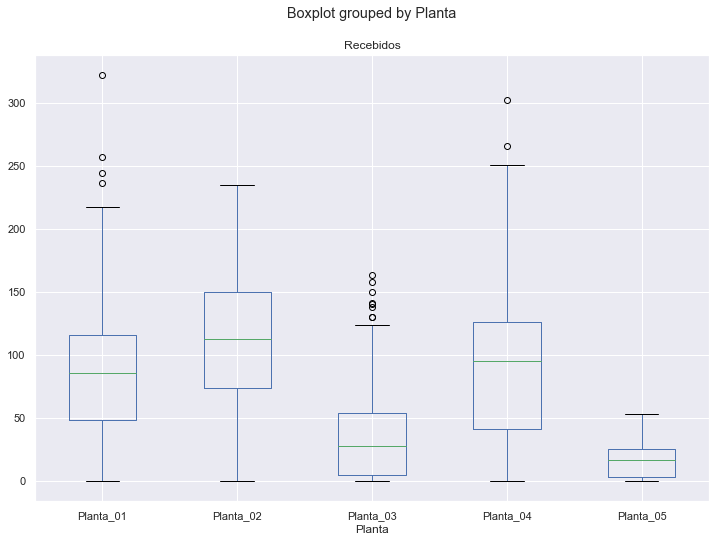

In [135]:
boxplot = dados.boxplot(column=['Recebidos'], by='Planta')

O desvio padrão elevado e a presença de outliers (principalmente na planta 3) reforçam a necessidade de um método de previsão que possa compreender a variabilidade dos dados.

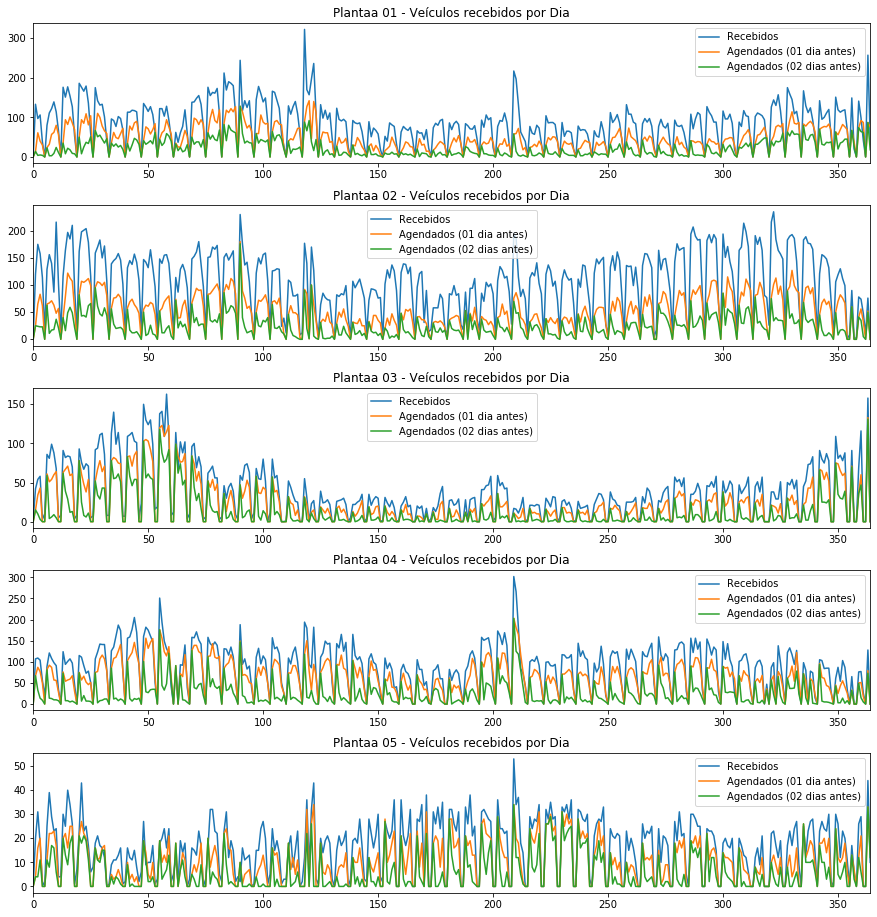

In [12]:
# Resolver problema data no Eixo X
#axes[0].set_xticklabels('Data', fontdict=['Data'])
#ax.set_xticklabels(<your labels>, rotation=0)
#plt.xlabel("Days")
#plt.xticks(np.arange(0, 366, 30))

# Criar figura para plotagem com 5 linhas e uma coluna
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15,16))
fig.subplots_adjust(hspace=0.3)

# Plotar valores para os campos "Recebidos" e "Agendados"
df_p01['Recebidos'].plot(ax = axes[0])
df_p01['Agendados (01 dia antes)'].plot(ax = axes[0])
df_p01['Agendados (02 dias antes)'].plot(ax = axes[0])

df_p02['Recebidos'].plot(ax = axes[1])
df_p02['Agendados (01 dia antes)'].plot(ax = axes[1])
df_p02['Agendados (02 dias antes)'].plot(ax = axes[1])

df_p03['Recebidos'].plot(ax = axes[2])
df_p03['Agendados (01 dia antes)'].plot(ax = axes[2])
df_p03['Agendados (02 dias antes)'].plot(ax = axes[2])

df_p04['Recebidos'].plot(ax = axes[3])
df_p04['Agendados (01 dia antes)'].plot(ax = axes[3])
df_p04['Agendados (02 dias antes)'].plot(ax = axes[3])

df_p05['Recebidos'].plot(ax = axes[4])
df_p05['Agendados (01 dia antes)'].plot(ax = axes[4])
df_p05['Agendados (02 dias antes)'].plot(ax = axes[4])


# Definir o título e legenda para cada gráfico
axes[0].set_title('Plantaa 01 - Veículos recebidos por Dia')
axes[0].legend(['Recebidos', 'Agendados (01 dia antes)', 'Agendados (02 dias antes)'])

axes[1].set_title('Plantaa 02 - Veículos recebidos por Dia')
axes[1].legend(['Recebidos', 'Agendados (01 dia antes)', 'Agendados (02 dias antes)'])

axes[2].set_title('Plantaa 03 - Veículos recebidos por Dia')
axes[2].legend(['Recebidos', 'Agendados (01 dia antes)', 'Agendados (02 dias antes)'])

axes[3].set_title('Plantaa 04 - Veículos recebidos por Dia')
axes[3].legend(['Recebidos', 'Agendados (01 dia antes)', 'Agendados (02 dias antes)'])

axes[4].set_title('Plantaa 05 - Veículos recebidos por Dia')
axes[4].legend(['Recebidos', 'Agendados (01 dia antes)', 'Agendados (02 dias antes)'])

Todas as plantas apresentam um ciclo semanal que normalmente tem picos às segundas-feiras.

Aparentemente nas plantas 3 a 5, a previsibilidade de um dia é melhor do que nas duas primeiras, Já em todas as plantas a previsibilidade de 2 dias é bastante baixa.

Todas plantas apresentam comportamento de picos ao longo seja em dias específicos ou também semanas.

Na próxima sessão vamos definir critérios objetivos para quantificar essas opiniões.

## 2.3) Critérios de avaliação

## PEGAR TEXTO FINAL APÓS ARTIGO

**Métricas de erro**


**Diferença básicas entre os modelos**


**Treinamento e Teste**


**Backtesting**


**Critério final de avaliação**


---
# 4) Modelos: Agendamento e Técnicas de Previsão em Séries Temporais

Para demonstração de cada modelo será utilizada uma amostra contendo os dados da Planta 01 no período de 01/01/2019 a 01/09/2019 para treino e 02/09/2019 a 15/09/2019 para teste. É necessária uma abordagem objetiva devido o excesso de combinações, sendo 120 (5 plantas x 12 amostras de teste x 2 métodos de amostragem de treino e teste).

Os ranges de índice do dataframe são:

Treino 
- Início: 01/01 - índice 0
- Fim: 01/09 - índice 243

Teste
- Início: 02/09 - índice 244
- Fim: 15/09 - índice 257

Ao invés de utilizar os datasets de cada planta, será criada uma cópia para execução de cada modelo, já que alguns modelos exigem modificações nos dados e resumir a amostra apenas para o período de testes onde será calculado o erro.

In [13]:
# Conforme consta na documentação do Pandas: ".iloc[] is primarily integer position based (from 0 to length-1 of the axis)", o ínidice final será 257+1

# Criar dataframe para calculo do Erro de previsão do Agendamento
df_agd = df_p01.iloc[244:258]

In [14]:
df_agd

,Planta,Data,Recebidos,Agendados (01 dia antes),Agendados (02 dias antes)
244,Planta_01,2019-09-02,66.0,14.0,13.0
245,Planta_01,2019-09-03,53.0,37.0,9.0
246,Planta_01,2019-09-04,50.0,29.0,5.0
247,Planta_01,2019-09-05,89.0,33.0,8.0
248,Planta_01,2019-09-06,65.0,39.0,7.0
249,Planta_01,2019-09-07,23.0,27.0,7.0
250,Planta_01,2019-09-08,0.0,0.0,0.0
251,Planta_01,2019-09-09,112.0,33.0,32.0
252,Planta_01,2019-09-10,87.0,49.0,12.0
253,Planta_01,2019-09-11,95.0,50.0,19.0


In [15]:
# O mesmo intervalo será replicado para os demais dataframes

# Modelo Média Móvel
df_mm = df_p01.copy()
df_mm_teste = df_p01.iloc[244:258].copy()

# Modelo Suavização Exponencial
df_se = df_p01.copy()
df_se_treino = df_p01.iloc[0:244].copy()
df_se_teste = df_p01.iloc[244:258].copy()

# Modelo SARIMA
df_sa = df_p01.copy()
df_sa_treino = df_p01.iloc[0:244].copy()
df_sa_teste = df_p01.iloc[244:258].copy()

# Modelo LSTM
df_lstm = df_p01.copy()
df_lstm_treino = df_p01.iloc[0:244].copy()
df_lstm_teste = df_p01.iloc[244:258].copy()

## 4.1) Previsibilidade do Sistema de Agendamento

Ao agendar um veículo o transportador ou fornecedor escolhe uma data/hora no sistema. A partir do agendamento cada planta tem a quantidade exata de veículos previstos para um dado dia, turno ou horário. Conforme mencionado na introdução, existe um perfil específico de operação em que os agendamentos são realizados com pouca antecedência. Essa previsão será considerada como “Agendamento” na tabela de comparação.

Ao invés de plotar todas as curvas no mesmo gráfico, será plotado um gráfico de cada vez comparando a quantidade de veículos recebidos com os previstos pelo Agendamento. Abaixo de cada gráfico seguirá o cálculo do erro de cada previsão.

In [16]:
# Importar bibliotecas para cálculo do erro de previsão
from sklearn.metrics import mean_squared_error
from math import sqrt

**Agendamento com 01 dia de antecedência**

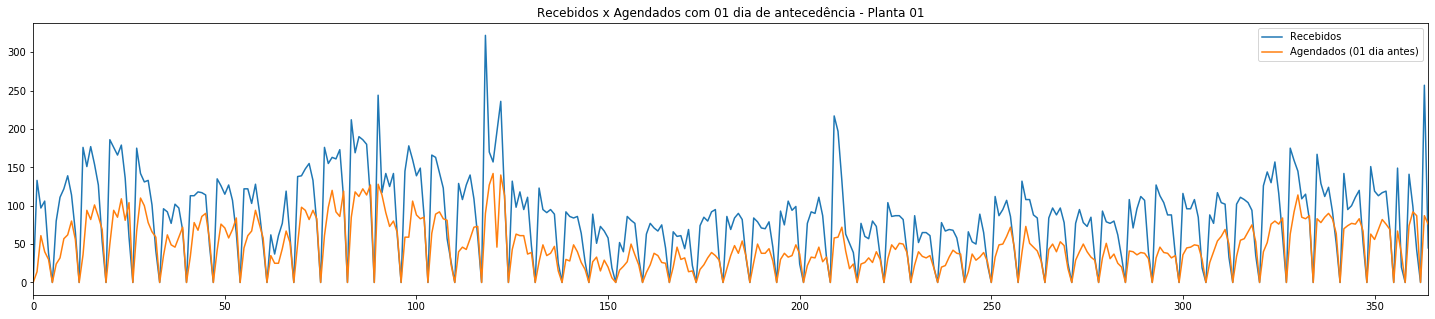

In [17]:
df_p01[['Recebidos', 'Agendados (01 dia antes)']].plot(figsize=(25,5), title='Recebidos x Agendados com 01 dia de antecedência - Planta 01', style=['-','-'])

In [18]:
rmse_agd01 = sqrt(mean_squared_error(df_agd['Recebidos'], df_agd['Agendados (01 dia antes)']))
print('O erro de previsão (RMSE) do Sistema de Agendamento com 01 dia de antecedência é: %.3f' % rmse_agd01)

O erro de previsão (RMSE) do Sistema de Agendamento com 01 dia de antecedência é: 37.180


**Agendamento com 02 dias de antecedência**

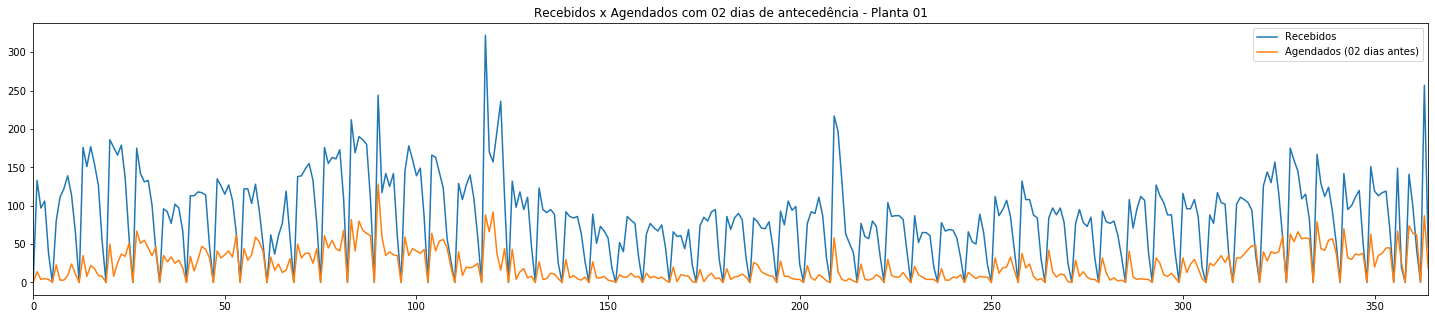

In [19]:
df_p01[['Recebidos', 'Agendados (02 dias antes)']].plot(figsize=(25,5), title='Recebidos x Agendados com 02 dias de antecedência - Planta 01', style=['-','-'])

In [20]:
rmse_agd02 = sqrt(mean_squared_error(df_agd['Recebidos'], df_agd['Agendados (02 dias antes)']))
print('O erro de previsão (RMSE) do Sistema de Agendamento com 02 dias de antecedência é: %.3f' % rmse_agd02)

O erro de previsão (RMSE) do Sistema de Agendamento com 02 dias de antecedência é: 57.233


Ao longo de 14 dias a previsibilidade obtida pelo sistema de agendamento varia em média +-37 veículos por dia quando se deseja ter uma previsão diária e a cada 02 dias essa variação é em +-57 veículos.

No caso da planta 1 que recebe uma média de 83,9 veículos, a previsibilidade de 2 dias é quase equivalente ao desvio padrão (54,3). 

## 4.2) Técnica de Previsão - Média Móvel (abordagem naive)

A primeira técnica estatística utilizada é a Média Móvel. Por se tratar de um método bastante simples vamos chamá-la sesse trabalho de abordagem naive (ingênua).

A média Móvel é baseada na ideia de que a demanda futura é similar a demanda recente observada. Com esse modelo nós simplesmente assumimos que a previsão é a média da demanda durante os últimos n períodos. Se verificarmos a demanda em uma base mensal, podemos traduzir como "A previsão de demanda em junho será a média entre março, abril e maio". (Livro Forecasting)

Um problema da média móvel aplicada aos dados utilizados é que pode ocorrer o cálculo de valores negativos, o que não faz sentido para o processo avaliado (já que não há expediente aos domingos, salvo poucas exceções). Para definir o ajuste do modelo, vamos avaliar 4 cenários, sendo as variações a quantidade de períodos e ajustando os resultados para fazer com que qualquer valor negativo seja igual a 0, sendo:

- a) Média Móvel padrão com 7 períodos
- b) Média Móvel forçando valores negativos a 0 com 7 períodos
- c) Média Móvel padrão com 3 períodos
- d) Média Móvel forçando valores negativos a 0 com 3 períodos


In [21]:
# Itera linha a linha do Dataframe e atribui o valor 0 para as 6 primeiras linhasduas primeiras linhas
# A partir da terceira linha, soma as 7 linhas anteriores e divide por 7
for index, row in df_mm.iterrows():
    
    if index <= 6:
        df_mm.at[index, "M01 y-hat_7p"] = 0
    else:
        df_mm.at[index, "M01 y-hat_7p"] = (df_mm.at[index-6, 'Recebidos'] + df_mm.at[index-5, 'Recebidos'] + 
                                           df_mm.at[index-4, 'Recebidos'] + df_mm.at[index-3, 'Recebidos'] + 
                                           df_mm.at[index-2, 'Recebidos'] + df_mm.at[index-1, 'Recebidos'] + 
                                           df_mm.at[index, 'Recebidos']) / 7

In [22]:
# Itera linha a linha do Dataframe e atribui o valor 0 para as 2 primeiras linhasduas primeiras linhas
# A partir da terceira linha, soma as 3 linhas anteriores e divide por 3
for index, row in df_mm.iterrows():
    
    if index == 0 or index == 1:
        df_mm.at[index, "M01 y-hat_3p"] = 0
    else:
        df_mm.at[index, "M01 y-hat_3p"] = (df_mm.at[index-2, 'Recebidos'] + df_mm.at[index-1, 'Recebidos'] + 
                                           df_mm.at[index, 'Recebidos']) / 3

In [23]:
# Itera linha a linha do Dataframe a partir da 7a linha e calcula: Recebidos - y-hat
for index, row in df_mm.iterrows():
    
    if index == 0 or index == 1:
        df_mm.at[index, "M01 Media Movel_7p"] = 0
    else:
        df_mm.at[index, "M01 Media Movel_7p"] = df_mm.at[index, 'Recebidos'] - df_mm.at[index, "M01 y-hat_7p"]

In [24]:
# Itera linha a linha do Dataframe a partir da 7a linha e calcula: Recebidos - y-hat
# Se o resultado for negativo atribui-se 0
for index, row in df_mm.iterrows():
    
    if df_mm.at[index, "M01 Media Movel_7p"] < 0:
        df_mm.at[index, "M01 Media Movel_7p0"] = 0
    else:
        df_mm.at[index, "M01 Media Movel_7p0"] = df_mm.at[index, "M01 Media Movel_7p"] 

In [25]:
# Itera linha a linha do Dataframe a partir da 3a linha e calcula: Recebidos - y-hat
for index, row in df_mm.iterrows():
    
    if index == 0 or index == 1:
        df_mm.at[index, "M01 Media Movel_3p"] = 0
    else:
        df_mm.at[index, "M01 Media Movel_3p"] = df_mm.at[index, 'Recebidos'] - df_mm.at[index, "M01 y-hat_3p"]

In [26]:
# Itera linha a linha do Dataframe a partir da 3a linha e calcula: Recebidos - y-hat
# Se o resultado for negativo atribui-se 0
for index, row in df_mm.iterrows():
    
    if df_mm.at[index, "M01 Media Movel_3p"] < 0:
        df_mm.at[index, "M01 Media Movel_3p0"] = 0
    else:
        df_mm.at[index, "M01 Media Movel_3p0"] = df_mm.at[index, "M01 Media Movel_3p"]

In [27]:
df_mm.head()

,Planta,Data,Recebidos,Agendados (01 dia antes),Agendados (02 dias antes),M01 y-hat_7p,M01 y-hat_3p,M01 Media Movel_7p,M01 Media Movel_7p0,M01 Media Movel_3p,M01 Media Movel_3p0
0,Planta_01,2019-01-01,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
1,Planta_01,2019-01-02,133.0,14.0,14.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
2,Planta_01,2019-01-03,97.0,61.0,4.0,0.0,76.666667,97.0,97.0,20.333333,20.333333
3,Planta_01,2019-01-04,106.0,40.0,5.0,0.0,112.000000,106.0,106.0,-6.000000,0.000000
4,Planta_01,2019-01-05,38.0,30.0,4.0,0.0,80.333333,38.0,38.0,-42.333333,0.000000


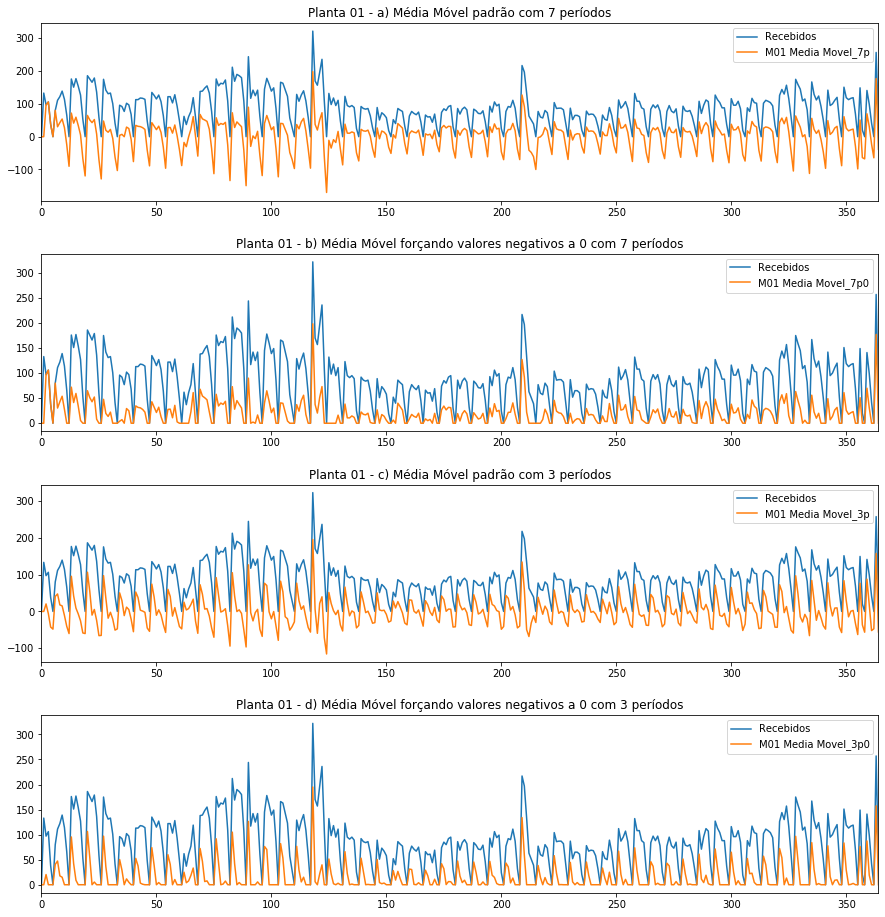

In [28]:
# Criar figura para plotagem com 5 linhas e uma coluna
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15,16))
fig.subplots_adjust(hspace=0.3)

# Plotar valores para os campos "Recebidos" e "Média Móvel" de acordo com o cenário
df_mm['Recebidos'].plot(ax = axes[0])
df_mm['M01 Media Movel_7p'].plot(ax = axes[0])

df_mm['Recebidos'].plot(ax = axes[1])
df_mm['M01 Media Movel_7p0'].plot(ax = axes[1])

df_mm['Recebidos'].plot(ax = axes[2])
df_mm['M01 Media Movel_3p'].plot(ax = axes[2])

df_mm['Recebidos'].plot(ax = axes[3])
df_mm['M01 Media Movel_3p0'].plot(ax = axes[3])

# Definir o título e legenda para cada gráfico
axes[0].set_title('Planta 01 - a) Média Móvel padrão com 7 períodos')
axes[0].legend(['Recebidos', 'M01 Media Movel_7p'])

# Definir o título e legenda para cada gráfico
axes[1].set_title('Planta 01 - b) Média Móvel forçando valores negativos a 0 com 7 períodos')
axes[1].legend(['Recebidos', 'M01 Media Movel_7p0'])

# Definir o título e legenda para cada gráfico
axes[2].set_title('Planta 01 - c) Média Móvel padrão com 3 períodos')
axes[2].legend(['Recebidos', 'M01 Media Movel_3p'])

# Definir o título e legenda para cada gráfico
axes[3].set_title('Planta 01 - d) Média Móvel forçando valores negativos a 0 com 3 períodos')
axes[3].legend(['Recebidos', 'M01 Media Movel_3p0'])


In [29]:
rmse_mm = sqrt(mean_squared_error(df_mm["Recebidos"], df_mm["M01 Media Movel_7p"]))
print('O erro de previsão (RMSE) do modelo Média Móvel - cenário A é:  %.3f' % rmse_mm)

O erro de previsão (RMSE) do modelo Média Móvel - cenário A é:  87.505


In [30]:
rmse_mm = sqrt(mean_squared_error(df_mm["Recebidos"], df_mm["M01 Media Movel_7p0"]))
print('O erro de previsão (RMSE) do modelo Média Móvel - cenário B é:  %.3f' % rmse_mm)

O erro de previsão (RMSE) do modelo Média Móvel - cenário B é:  75.213


In [31]:
rmse_mm = sqrt(mean_squared_error(df_mm["Recebidos"], df_mm["M01 Media Movel_3p"]))
print('O erro de previsão (RMSE) do modelo Média Móvel - cenário C é:  %.3f' % rmse_mm)

O erro de previsão (RMSE) do modelo Média Móvel - cenário C é:  91.801


In [32]:
rmse_mm = sqrt(mean_squared_error(df_mm["Recebidos"], df_mm["M01 Media Movel_3p0"]))
print('O erro de previsão (RMSE) do modelo Média Móvel - cenário D é:  %.3f' % rmse_mm)

O erro de previsão (RMSE) do modelo Média Móvel - cenário D é:  81.354


**O cenário que proporcionou o melhor resultado foi o b. Essa será o cenário definido para execução em lote e vamos chamá-lo de "Média Móvel Ajustada (naive)".**

## 4.3) Suavização Expoencial

Os métodos de suavização exponencial frequentemente são chamados de "Holt-Winters", em referência aos nomes dos pesquisadores que propiseram esses modelos. Uma forma inicial de previsão por suavização exponencial foi proposta por R.G. Brown in 1956. Suas equações foram refinadas em 1957 por Charles C. Holt - um engenheiro americado do MIT e Universidade de Chicago - em seu artigo "Forecasting Trends and Seasonals by Exponentially Weighted Averages"[Livro Forecast]. Os modelos de suavização exponencial foram novamente melhorados 3 anos depois por Peter Winters[Livro Forecast]. Ambos nomes foram lembrados e atribuídos para todas diferentes técnicas que muitas das vezes são chamadas de "Holt-Winters".


O modelo sazonal Holt-Winters compreende a equação de previsão e três equações de suavização - pelo nível (Lt), pela Tendência (Bt) e pelo componente de sazionalidade (St), com os correspondentes parâmetros de suavização ALPHA, BETA e GAMA. Utiliza-se M para denotar a frequência da sazonalidade como M=12 para o período de 1 ano.

Esse método ainda permite duas variações que diferem em natureza do componente sazonal. O método aditivo é preferido com as variações sazonais são aproximadamente constantes ao longo da série enquanto o método multiplicativo é melhor quando as variações sazonais são alteradas em proporção ao nível da série.

**Pré-processamento dos Dados**

In [33]:
# Definir a coluna "Data" como índice dos dataframes
df_se.index = df_se["Data"]
df_se_treino.index = df_se_treino["Data"]
df_se_teste.index = df_se_teste["Data"]

In [34]:
# Verificar o nome das colunas para apagar as desnecessárias (como os dataframes possuem as mesmas colunas a verificação é feita somente uma vez)
df_se.columns

Index(['Planta', 'Data', 'Recebidos', 'Agendados (01 dia antes)',
       'Agendados (02 dias antes)'],
      dtype='object')

In [35]:
# Apagar colunas desnecessárias
df_se.drop(['Planta', 'Data', 'Agendados (01 dia antes)',
       'Agendados (02 dias antes)'], axis=1, inplace=True)

In [36]:
# Apagar colunas desnecessárias
df_se_treino.drop(['Planta', 'Data', 'Agendados (01 dia antes)',
       'Agendados (02 dias antes)'], axis=1, inplace=True)

In [37]:
# Apagar colunas desnecessárias
df_se_teste.drop(['Planta', 'Data', 'Agendados (01 dia antes)',
       'Agendados (02 dias antes)'], axis=1, inplace=True)

In [38]:
# Transforma o objeto Pandas Dataframe de cada dataframe em um objeto Pandas Series, formato necessário para input no modelo
df_se = df_se_teste['Recebidos']
df_se_treino = df_se_treino['Recebidos']
df_se_teste = df_se_teste['Recebidos']

In [39]:
# Confirma que o Dataframe foi transformado em uma série
print (isinstance(df_se, pd.Series))
print (isinstance(df_se_treino, pd.Series))
print (isinstance(df_se_teste, pd.Series))

True
True
True


In [40]:
# Exibe Série de Treino
df_se.head()

Data
2019-09-02    66.0
2019-09-03    53.0
2019-09-04    50.0
2019-09-05    89.0
2019-09-06    65.0
Name: Recebidos, dtype: float64

In [41]:
# Exibe Série de Treino
df_se_treino.head()

Data
2019-01-01      0.0
2019-01-02    133.0
2019-01-03     97.0
2019-01-04    106.0
2019-01-05     38.0
Name: Recebidos, dtype: float64

In [42]:
# Exibe Série de Teste
df_se_teste.head()

Data
2019-09-02    66.0
2019-09-03    53.0
2019-09-04    50.0
2019-09-05    89.0
2019-09-06    65.0
Name: Recebidos, dtype: float64

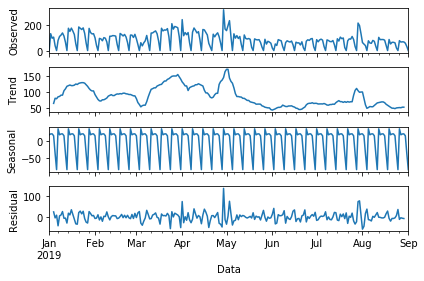

In [43]:
# Realiza a decomposição dos fatores da série
import statsmodels.api as sm

sm.tsa.seasonal_decompose(df_se_treino).plot()
result = sm.tsa.stattools.adfuller(df_se_treino)
plt.show()

Essa função da biblioteca Statsmodel realiza a decomposição da série e com ela podemos tirar conclusões úteis para a parametrização do modelo:
- A tendência varia no primeiro semestre seguida de uma queda mantida durante boa parte do segundo semestre.
- A sazonalidade é bem definida em ciclos semanais.

Como a tendência não se eleva ao longo do período (e isso já foi observado nas demais plantas) os parâmetros de tendência e sazonalidade serão "aditivos" e o período de sazonalidade será 7 (dias).

**Execução do Modelo**

In [44]:
# Importar bibliotecas
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
from statsmodels.tsa.api import Holt
#from sklearn.metrics import mean_squared_error

In [45]:
# Copia o índice do dataframe de teste para a variável y_hat
y_hat_se = df_se_teste.index.copy()

# Treinamento do Modelo
fit_se = ExponentialSmoothing(df_se_treino, trend="add", seasonal="add", seasonal_periods=7).fit()

In [46]:
y_hat_se = fit_se.forecast(len(df_se_teste))

In [47]:
y_hat_se

2019-09-02    90.347183
2019-09-03    75.378086
2019-09-04    76.602998
2019-09-05    75.713829
2019-09-06    73.012736
2019-09-07    31.822348
2019-09-08    -7.507155
2019-09-09    90.885028
2019-09-10    75.915931
2019-09-11    77.140843
2019-09-12    76.251674
2019-09-13    73.550581
2019-09-14    32.360193
2019-09-15    -6.969310
Freq: D, dtype: float64

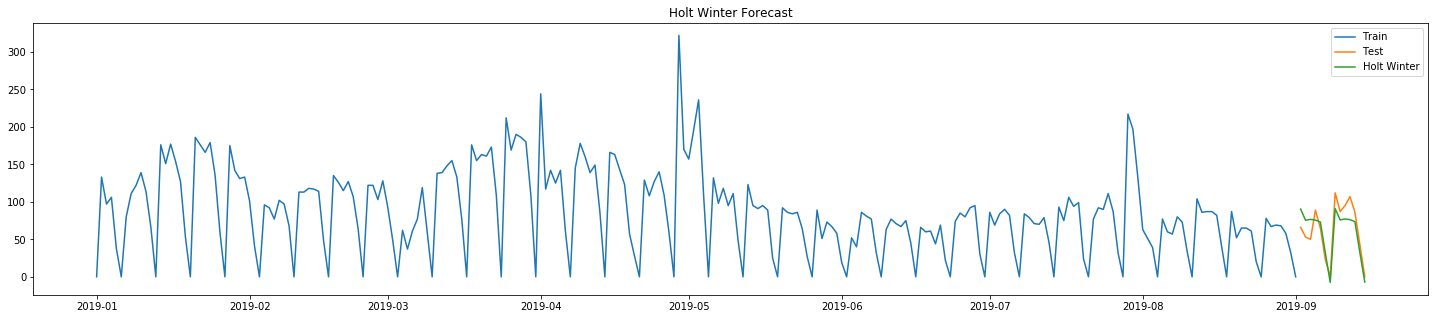

In [48]:

plt.figure(figsize=(25,5))
plt.plot(df_se_treino.index, df_se_treino, label='Train')
plt.plot(df_se_teste.index,df_se_teste, label='Test')
plt.plot(y_hat_se.index,y_hat_se, label='Holt Winter')
plt.legend(loc='best')
plt.title("Holt Winter Forecast")
plt.show()   

In [49]:
# Calcular RMSE
rmse_se = sqrt(mean_squared_error(df_se_teste, y_hat_se))
print('O erro de previsão (RMSE) do modelo Suavização Exponencial é: %.3f' % rmse_se)

O erro de previsão (RMSE) do modelo Suavização Exponencial é: 17.579


## 4.4) SARIMA

ARIMA (Autoregressive Integrated Moving Average) é uma das técnicas de previsão mais utilizadas, porém sua principal desvantagem é a ausência de um componente de sazonalidade. A técnica SARIMA (Seasonal Autoregressive Integrated Moving Average) conta com os seguintes parâmetros:


- Presentes também no ARIMA
    - p: Trend autoregression order.
    - d: Trend difference order.
    - q: Trend moving average order
- Fatores de Sazonalidade
    - P: Seasonal autoregressive order.
    - D: Seasonal difference order.
    - Q: Seasonal moving average order.
    - m: The number of time steps for a single seasonal period.

Dessa forma o modelo SARIMA pode ser definido como: (p, d, q) (P,D,Q) m


ESCREVER AO LONGO DO CÓDIGO
If m is 12, it specifies monthly data suggests a yearly seasonal cycle.

SARIMA time series models can also be combined with spatial and event based models to yield ensemble models that solves multi-dimensional ML problems. Such a ML model can be designed to predict cell load in cellular networks at different times of the day round the year as illustrated below in the sample figure

Autocorrelation, trend, and seasonality (weekday , weekend effects) from time series analysis can be used to interpret temporal influence.

Regional and cell wise load distribution can be used to predict sparse and over loaded cells in varying intervals of time.

Events (holidays, special mass gatherings and others) can be predicted using decision trees.

https://mc.ai/arima-sarima-vs-lstm-with-ensemble-learning-insights-for-time-series-data/

In [50]:
# Definir a coluna "Data" como índice dos dataframes
df_sa.index = df_sa["Data"]
df_sa_treino.index = df_sa_treino["Data"]
df_sa_teste.index = df_sa_teste["Data"]

In [51]:
# Apagar colunas desnecessárias
df_sa.drop(['Planta', 'Data', 'Agendados (01 dia antes)',
       'Agendados (02 dias antes)'], axis=1, inplace=True)

In [52]:
# Apagar colunas desnecessárias
df_sa_treino.drop(['Planta', 'Data', 'Agendados (01 dia antes)',
       'Agendados (02 dias antes)'], axis=1, inplace=True)

In [53]:
# Apagar colunas desnecessárias
df_sa_teste.drop(['Planta', 'Data', 'Agendados (01 dia antes)',
       'Agendados (02 dias antes)'], axis=1, inplace=True)

In [54]:
# Transforma o objeto Pandas Dataframe de cada dataframe em um objeto Pandas Series, formato necessário para input no modelo
df_sa = df_sa_teste['Recebidos']
df_sa_treino = df_sa_treino['Recebidos']
df_sa_teste = df_sa_teste['Recebidos']

In [55]:
df_sa_teste

Data
2019-09-02     66.0
2019-09-03     53.0
2019-09-04     50.0
2019-09-05     89.0
2019-09-06     65.0
2019-09-07     23.0
2019-09-08      0.0
2019-09-09    112.0
2019-09-10     87.0
2019-09-11     95.0
2019-09-12    107.0
2019-09-13     86.0
2019-09-14     43.0
2019-09-15      0.0
Name: Recebidos, dtype: float64

In [56]:
import statsmodels.api as sm

In [57]:
y_hat_sa = df_sa_teste.copy()

In [58]:
y_hat_sa

Data
2019-09-02     66.0
2019-09-03     53.0
2019-09-04     50.0
2019-09-05     89.0
2019-09-06     65.0
2019-09-07     23.0
2019-09-08      0.0
2019-09-09    112.0
2019-09-10     87.0
2019-09-11     95.0
2019-09-12    107.0
2019-09-13     86.0
2019-09-14     43.0
2019-09-15      0.0
Name: Recebidos, dtype: float64

In [59]:
fit_sa = sm.tsa.statespace.SARIMAX(df_sa_treino, order=(1, 0, 0),seasonal_order=(1,1,7,7)).fit()

In [60]:
print(fit_sa)

In [61]:
y_hat_sa

Data
2019-09-02     66.0
2019-09-03     53.0
2019-09-04     50.0
2019-09-05     89.0
2019-09-06     65.0
2019-09-07     23.0
2019-09-08      0.0
2019-09-09    112.0
2019-09-10     87.0
2019-09-11     95.0
2019-09-12    107.0
2019-09-13     86.0
2019-09-14     43.0
2019-09-15      0.0
Name: Recebidos, dtype: float64

In [62]:
y_hat_sa = fit_sa.forecast(len(df_se_teste))

In [63]:
y_hat_sa

2019-09-02     95.898630
2019-09-03     77.233030
2019-09-04     79.790281
2019-09-05     81.974729
2019-09-06     72.523332
2019-09-07     35.407571
2019-09-08     -0.830618
2019-09-09    104.746995
2019-09-10     87.112068
2019-09-11     87.838131
2019-09-12     86.408899
2019-09-13     79.876088
2019-09-14     41.556136
2019-09-15     -1.076269
Freq: D, dtype: float64

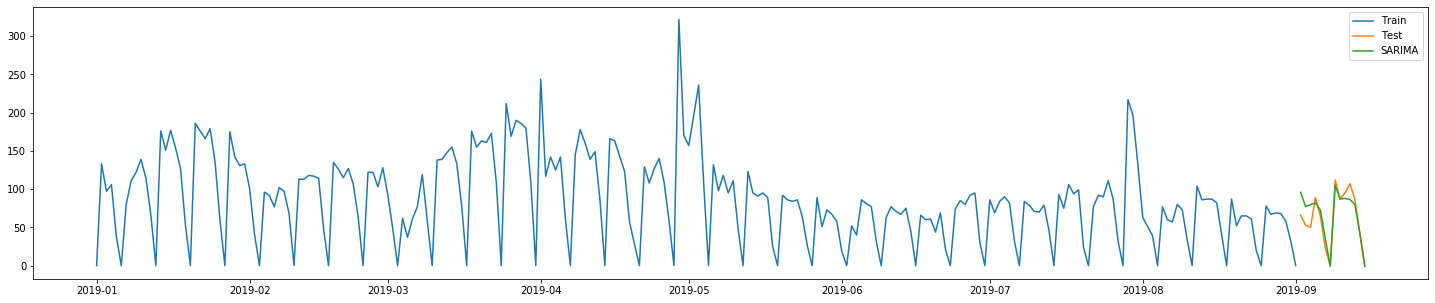

In [64]:
plt.figure(figsize=(25,5))
plt.plot(df_sa_treino.index, df_sa_treino, label='Train')
plt.plot(df_sa_teste.index, df_sa_teste, label='Test')
plt.plot(y_hat_sa.index, y_hat_sa, label='SARIMA')
plt.legend(loc='best')
plt.show()

In [65]:
# Calcular RMSE
rmse_sa = sqrt(mean_squared_error(df_sa_teste, y_hat_sa))
print('O erro de previsão (RMSE) do modelo SARIMA é: %.3f' % rmse_sa)

O erro de previsão (RMSE) do modelo SARIMA é: 15.114


## 4.5) Long Short Term Memory - LSTM

Uma Rede Neural Recorrente (Recurrent Neural Newtork - RNN) A recebe um input Xt e proporciona uma saída Ht. Essa característica encadeada permite com que uma informação seja passada de de forma sucessiva permitindo trabalhar com dados temporalmente sequenciais, popularizando essa técnica em aplicações como Processamento de Linguagem Natural e Tradução e Previsão de Séries Temporais. [site RNN]

imagem

Um dos problemas das RNNs é lidar com dependências de longo prazo, onde a rede pode “deixar” de propagar uma informação vários passos a frente. Para resolver esse problema foram desenvolvidas [paper LSTM] as Long-Short Term Memory (LSTM), um tipo de RNN capaz de aprender dependências de longo prazo. Em uma LSTM cada bloco contém "gates", que gerenciam o estado do bloco e sua saída. Um bloco opera sobre uma sequencia de inputs e cada "gate", dentro de um bloco usa uma função de ativação para controlar se essa função será ativada ou não, fazendo com que a mudança de estado e adição de informação flua através do bloco condicional [Jason Brownlee].

imagem

Apesar de ser popular na literatura e ter uma infinidade de tutoriais disponíveis as LSTMs são modelos considerados modelos complexos contando com elevados números de parâmetros, elevado custo computacional, difícil treino


**Pré-processamento dos Dados**

In [66]:
# Importar bibliotecas básicas
import torch
import torch.nn as nn

In [67]:
# Copiar valores da coluna "Recebidos" do Dataframe e armazenar em um array
all_data = df_lstm["Recebidos"].values

In [68]:
# Imprimir valores
print(all_data)

[  0. 133.  97. 106.  38.   0.  80. 111. 122. 139. 114.  66.   0. 176.
 151. 177. 154. 127.  53.   0. 186. 176. 166. 179. 136.  59.   0. 175.
 142. 131. 133. 101.  41.   0.  96.  92.  77. 102.  97.  68.   0. 113.
 113. 118. 117. 114.  48.   0. 135. 126. 115. 127. 107.  64.   0. 122.
 122. 103. 128.  93.  49.   0.  62.  37.  61.  77. 119.  59.   0. 138.
 139. 148. 155. 133.  77.   0. 176. 155. 163. 161. 173. 109.   0. 212.
 169. 190. 186. 180. 109.   0. 244. 117. 142. 125. 142.  61.   0. 145.
 178. 160. 139. 149.  86.   0. 166. 163. 143. 123.  57.  28.   0. 129.
 108. 127. 140. 109.  59.   0. 322. 170. 157. 196. 236. 110.   0. 132.
  98. 118.  95. 111.  48.   0. 123.  95.  91.  95.  89.  25.   0.  92.
  86.  84.  86.  64.  27.   0.  89.  51.  73.  67.  58.  19.   0.  52.
  40.  86.  81.  77.  32.   0.  63.  77.  71.  67.  75.  45.   0.  66.
  60.  61.  44.  69.  22.   0.  74.  85.  80.  92.  95.  30.   0.  86.
  69.  84.  90.  82.  32.   0.  84.  79.  71.  70.  79.  46.   0.  93.
  75. 

In [69]:
# Definir o tamanho da janela de predição (14 dias)
test_data_size = 14

# Copiar datasets para arrays (treino e teste)
train_data = df_lstm_treino['Recebidos']
test_data = df_lstm_teste['Recebidos']

In [70]:
# Conferir quantidade de linhas para cada array
print(len(train_data))
print(len(test_data))

244
14


In [71]:
# Imprimir o array de teste
print(test_data)

244     66.0
245     53.0
246     50.0
247     89.0
248     65.0
249     23.0
250      0.0
251    112.0
252     87.0
253     95.0
254    107.0
255     86.0
256     43.0
257      0.0
Name: Recebidos, dtype: float64


**Normalização dos Dados**

É extremamente recomendado normalizar os dados para redes neurais e para isso será utilizado o Min/Max Scaling no range de -1 a 1.
Um ponto importante é que a normalização só é realizada no dataset de treino.

In [72]:
# Definindo 
from sklearn.preprocessing import MinMaxScaler

# Normalizar dados no range de -1 a 1
scaler = MinMaxScaler(feature_range=(-1, 1))

#Criar array com dados Normalizados
train_data_normalized = scaler.fit_transform(train_data.values.reshape(-1, 1))

In [73]:
# Mostrar os 5 primeiros e últimos valores normalizados do array de treino
print(train_data_normalized[:5])
print(train_data_normalized[-5:])

[[-1.        ]
 [-0.17391304]
 [-0.39751553]
 [-0.34161491]
 [-0.76397516]]
[[-0.57142857]
 [-0.57763975]
 [-0.63975155]
 [-0.80124224]
 [-1.        ]]


In [74]:
# Converter dataset de treino em um tensor, já que modelos do PyTorch são treinados usando tensores
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

O último passo do pré-processamento é converter os dados de treino em sequências e labels correspondente.

A sequência corresponte ao período dos dados. Como os ciclos semanais será considerado o valor 7.

In [75]:
# Define janela de treino de acordo com a sequência dos dados
train_window = 7

In [76]:
# Explicar função
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq, train_label))
    return inout_seq

In [77]:
# Executar função com os parâmetros definidos acima e armazenar dados na variavel train_inout_seq
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [78]:
train_inout_seq[:5]

[(tensor([-1.0000, -0.1739, -0.3975, -0.3416, -0.7640, -1.0000, -0.5031]),
  tensor([-0.3106])),
 (tensor([-0.1739, -0.3975, -0.3416, -0.7640, -1.0000, -0.5031, -0.3106]),
  tensor([-0.2422])),
 (tensor([-0.3975, -0.3416, -0.7640, -1.0000, -0.5031, -0.3106, -0.2422]),
  tensor([-0.1366])),
 (tensor([-0.3416, -0.7640, -1.0000, -0.5031, -0.3106, -0.2422, -0.1366]),
  tensor([-0.2919])),
 (tensor([-0.7640, -1.0000, -0.5031, -0.3106, -0.2422, -0.1366, -0.2919]),
  tensor([-0.5901]))]

**Criando o modelo LSTM**

Será definida uma Classe LSTM.

O "construtor" da classe aceita 3 parâmetros
- "input_size" que corresponde com o número de features no input. O Dataset completo tem 365 dias e como cada dia apresenta apenas um valor de veículo recebido, o input size será 1.
- "hidden_layer_size" especifica o número de camadas ocultas em torno do número de neurônios em cada camada. Vamos considerar uma camada com 100 neurônios.
- "output_size" representa o número de itens na saída. Como queremos prever a quantidade de veículos para 1 dia de cada vezes o output size será 1.

No método "forward" o "input_seq" é passado como parâmetro que primeiramente passa pela camada LSTM. A saída da camada LSTM é o estado oculto e da célula no passo corrente. A saída da camada LSTM é passada para a camada linear. A previsão de veículos é armazenada no último item da lista de predições, que é retornada.

In [79]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                           torch.zeros(1,1,self.hidden_layer_size))
    
    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [80]:
# Criar objeto da classe LSTM, definindo a função de perda e otimizador
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [81]:
# Imprimir modelo
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


**Treinando o Modelo**

O Modelo será treinado em 100 épocas e a cada 25 será informado o valor da Loss.

In [82]:
epochs = 25

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1,1, model.hidden_layer_size),
                             torch.zeros(1,1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

epoch:   1 loss: 0.08198800


In [83]:
print(loss_function)

MSELoss()


**Realizando a Previsão**

Agora que o modelo está treinado é possível começar a fazer as previsões. A amostra de teste contém dados dos últimos 8 meses e nosso modelo é treinado para fazer prever os próximos 14 dias.

In [84]:
# Definir janela de predição em 14 dias
fut_pred = 14

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[-0.5155279636383057, -0.5838509202003479, -0.5714285969734192, -0.5776397585868835, -0.6397515535354614, -0.8012422323226929, -1.0]


In [85]:
# Executar a previsão para os 14 próximos dias
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1, model.hidden_layer_size), torch.zeros(1,1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [86]:
test_inputs[fut_pred:]

[-0.3519466519355774,
 -1.062129259109497,
 -0.9864130020141602,
 -0.8943790793418884,
 -0.9118807911872864,
 -0.6678606867790222,
 -0.37105438113212585]

Com a normalização dos dados a previsão é informada considerando o intervalo de -1 a 1. Para obter a previsão de forma adequada basta reverter a normalização.

In [87]:
# Reverter normalização e exibir previsões
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1,1))
print(actual_predictions)

[[  0.32068115]
 [ 33.62727249]
 [ 79.56575716]
 [108.85484707]
 [ 94.01736754]
 [ 89.56384647]
 [113.3804847 ]
 [104.33658904]
 [-10.00281072]
 [  2.18750668]
 [ 17.00496823]
 [ 14.18719262]
 [ 53.47442943]
 [101.26024464]]


In [88]:
df_lstm_teste["M05 LSTM"] = np.nan


In [89]:
j = 0
for index, row in df_lstm_teste.iterrows():
    df_lstm_teste.at[index, "M05 LSTM"] = actual_predictions[j]
    j += 1

In [90]:
df_lstm_teste

,Planta,Data,Recebidos,Agendados (01 dia antes),Agendados (02 dias antes),M05 LSTM
244,Planta_01,2019-09-02,66.0,14.0,13.0,0.320681
245,Planta_01,2019-09-03,53.0,37.0,9.0,33.627272
246,Planta_01,2019-09-04,50.0,29.0,5.0,79.565757
247,Planta_01,2019-09-05,89.0,33.0,8.0,108.854847
248,Planta_01,2019-09-06,65.0,39.0,7.0,94.017368
249,Planta_01,2019-09-07,23.0,27.0,7.0,89.563846
250,Planta_01,2019-09-08,0.0,0.0,0.0,113.380485
251,Planta_01,2019-09-09,112.0,33.0,32.0,104.336589
252,Planta_01,2019-09-10,87.0,49.0,12.0,-10.002811
253,Planta_01,2019-09-11,95.0,50.0,19.0,2.187507


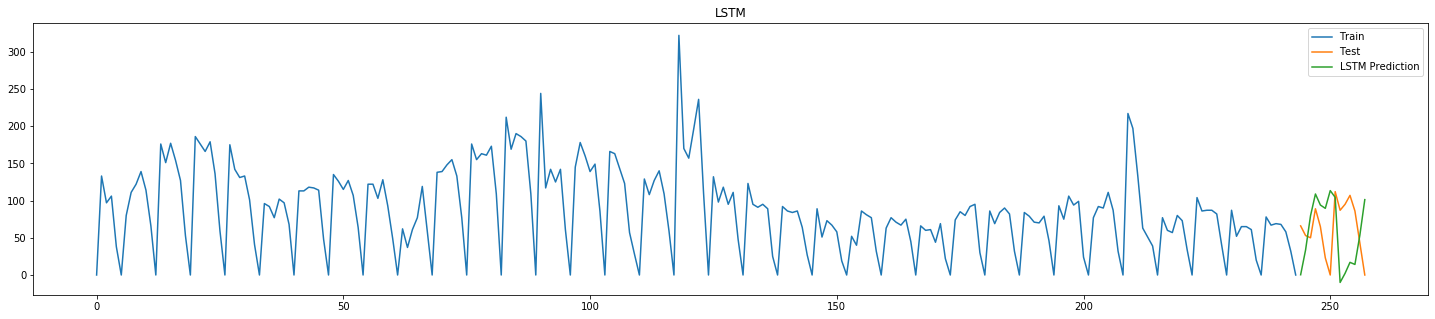

In [91]:
# grafico utilizado no exponential smoothing

plt.figure(figsize=(25,5))
plt.plot(df_lstm_treino["Recebidos"], label='Train')
plt.plot(df_lstm_teste["Recebidos"], label='Test')
plt.plot(df_lstm_teste["M05 LSTM"], label='LSTM Prediction')
#plt.grid(True)
plt.legend(loc='best')
plt.title("LSTM")
plt.show()   

In [92]:
# Explicar as diferencas entre linhas e colunas

# fazer o período ficar restrito apenas ao 
rmse_lstm = sqrt(mean_squared_error(df_lstm_teste["Recebidos"], df_lstm_teste["M05 LSTM"]))
print('O erro de previsão (RMSE) do modelo LSTM é: %.3f' % rmse_lstm)

O erro de previsão (RMSE) do modelo LSTM é: 68.550


## REVISAR

Citar resultados e ajustes de parâmetros realizados

---
# 5) Execução em Lote

Nessa sessão vamos resumir os códigos de cada modelo acima retirando as explicações e entendimento e colocando o essencial em funções específicas para execução e gravação dos resultados para posterior análise.

## 5.1) Funções para os modelos

In [93]:
# Importar todas bibliotecas dos modelos

# Importar bibliotecas para cálculo do erro de previsão
from sklearn.metrics import mean_squared_error
from math import sqrt

# Suavização Exponencial
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
from statsmodels.tsa.api import Holt

# SARIMA
import statsmodels.api as sm

# LSTM
import torch
import torch.nn as nn

In [94]:
# Armazenar dataframes de cada planta no array plantas
plantas = [df_p01, df_p02, df_p03, df_p04, df_p05]

In [95]:
# Função do modelo: 1 - Agendamento 01 dia (Baseline)
def m01_agd_1(df_agd1_teste): 
    
    # Estão comentados os trechos de código para conferência, mantendo apenas o código para registro dos resultados
    #print("Dataframe")
    #print(df_agd1_teste)
    #print("Gráfico")    

    # Gráfico     
    #plt.figure(figsize=(25,5))
    #plt.plot(df_agd1_teste.index, df_agd1_teste['Recebidos'], label='Recebidos')
    #plt.plot(df_agd1_teste.index, df_agd1_teste['Agendados (01 dia antes)'], label='Agd01')
    #plt.legend(loc='best')
    #plt.show()    
    
    rmse_agd01 = sqrt(mean_squared_error(df_agd1_teste['Recebidos'], df_agd1_teste['Agendados (01 dia antes)']))
    print('O erro de previsão (RMSE) do Sistema de Agendamento com 01 dia de antecedência é: %.3f' % rmse_agd01)
    
    return rmse_agd01 

In [96]:
# Função do modelo: 2 - Agendamento 02 dias
def m02_agd_2(df_agd2_teste):

    # Estão comentados os trechos de código para conferência, mantendo apenas o código para registro dos resultados
    #print("Dataframe")
    #print(df_agd2_teste)
    #print("Gráfico")    

    # Gráfico     
    #plt.figure(figsize=(25,5))
    #plt.plot(df_agd1_teste.index, df_agd2_teste['Recebidos'], label='Recebidos')
    #plt.plot(df_agd1_teste.index, df_agd2_teste['Agendados (02 dias antes)'], label='Agd01')
    #plt.legend(loc='best')
    #plt.show()        
    
    rmse_agd02 = sqrt(mean_squared_error(df_agd2_teste['Recebidos'], df_agd2_teste['Agendados (02 dias antes)']))
    print('O erro de previsão (RMSE) do Sistema de Agendamento com 02 dias de antecedência é: %.3f' % rmse_agd02)
    
    return rmse_agd02

In [97]:
# Função do modelo: 3 - Média Móvel (Naive) - Parte 1 - Atualiza Dataframes com a coluna de média móvel
def m03_media_movel(plantas):
    for planta in range(len(plantas)):

        # Itera linha a linha do Dataframe e atribui o valor 0 para as 6 primeiras linhasduas primeiras linhas
        # A partir da terceira linha, soma as 7 linhas anteriores e divide por 7
        for index, row in plantas[planta].iterrows():

            if index <= 6:
                plantas[planta].at[index, "MM_y-hat_7p"] = 0
            else:
                plantas[planta].at[index, "MM_y-hat_7p"] = (plantas[planta].at[index-6, 'Recebidos'] + plantas[planta].at[index-5, 'Recebidos'] + 
                                                            plantas[planta].at[index-4, 'Recebidos'] + plantas[planta].at[index-3, 'Recebidos'] + 
                                                            plantas[planta].at[index-2, 'Recebidos'] + plantas[planta].at[index-1, 'Recebidos'] + 
                                                            plantas[planta].at[index, 'Recebidos']) / 7

        # Itera linha a linha do Dataframe a partir da 7a linha e calcula: Recebidos - y-hat
        for index, row in plantas[planta].iterrows():

            if index == 0 or index == 1:
                plantas[planta].at[index, "MM_7p"] = 0
            else:
                plantas[planta].at[index, "MM_7p"] = plantas[planta].at[index, 'Recebidos'] - plantas[planta].at[index, "MM_y-hat_7p"]

        # Itera linha a linha do Dataframe a partir da 7a linha e calcula: Recebidos - y-hat
        # Se o resultado for negativo atribui-se 0
        for index, row in plantas[planta].iterrows():

            if index <= 6:
                plantas[planta].at[index, "MM_7p_adj0"] = 0
            elif plantas[planta].at[index, "MM_7p"] <= 0:
                plantas[planta].at[index, "MM_7p_adj0"] = 0
            else:
                plantas[planta].at[index, "MM_7p_adj0"] = plantas[planta].at[index, "MM_7p"]         

In [98]:
m03_media_movel(plantas)

In [99]:
df_p05.head()

,Planta,Data,Recebidos,Agendados (01 dia antes),Agendados (02 dias antes),MM_y-hat_7p,MM_7p,MM_7p_adj0
0,Planta_05,2019-01-01,0.0,0.0,0.0,0.0,0.0,0.0
1,Planta_05,2019-01-02,20.0,4.0,4.0,0.0,0.0,0.0
2,Planta_05,2019-01-03,31.0,16.0,4.0,0.0,31.0,0.0
3,Planta_05,2019-01-04,18.0,20.0,11.0,0.0,18.0,0.0
4,Planta_05,2019-01-05,2.0,0.0,0.0,0.0,2.0,0.0


In [100]:
# Função do modelo: 3 - Média Móvel (Naive) - Parte 2 - Calcula erro da Média Móvel

def m03_media_movel(df_mm_teste):

    # Estão comentados os trechos de código para conferência, mantendo apenas o código para registro dos resultados

    #print("Dataframe")
    #print(df_mm_teste)
    #print("Gráfico")

    # Gráfico     
    #plt.figure(figsize=(25,5))
    #plt.plot(df_mm_teste.index, df_mm_teste["Recebidos"], label='Recebidos')
    #plt.plot(df_mm_teste.index, df_mm_teste["MM_7p_adj0"], label='Média Móvel Ajustada - 7 períodos')
    #plt.legend(loc='best')
    #plt.title("Média Móvel")
    #plt.show()   
            
    rmse_mm = sqrt(mean_squared_error(df_mm_teste["Recebidos"], df_mm_teste["MM_7p_adj0"]))
    print('O erro de previsão (RMSE) do modelo Média Móvel ajustada em 7 períodos é:  %.3f' % rmse_mm)
    
    return rmse_mm

In [108]:
# Função do modelo: 4 - Suavização Exponencial (Holt-Winters)
def m04_suavizacao_exponencial(df_se, df_se_treino, df_se_teste):

    # Estão comentados os trechos de código para conferência, mantendo apenas o código para registro dos resultados
    #print("Dataframe")
    #print(df_se_teste)
    #print("Gráfico")
    
    # Definir a coluna "Data" como índice dos dataframes
    df_se.index = df_se["Data"]
    df_se_treino.index = df_se_treino["Data"]
    df_se_teste.index = df_se_teste["Data"]

    # Apagar colunas desnecessárias
    df_se.drop(['Planta', 'Data', 'Agendados (01 dia antes)',
           'Agendados (02 dias antes)'], axis=1, inplace=True)

    # Apagar colunas desnecessárias
    df_se_treino.drop(['Planta', 'Data', 'Agendados (01 dia antes)',
           'Agendados (02 dias antes)'], axis=1, inplace=True)

    # Apagar colunas desnecessárias
    df_se_teste.drop(['Planta', 'Data', 'Agendados (01 dia antes)',
           'Agendados (02 dias antes)'], axis=1, inplace=True)

    # Transforma o objeto Pandas Dataframe de cada dataframe em um objeto Pandas Series, formato necessário para input no modelo
    df_se = df_se_teste['Recebidos']
    df_se_treino = df_se_treino['Recebidos']
    df_se_teste = df_se_teste['Recebidos']

    # Copia o índice do dataframe de teste para a variável y_hat
    y_hat_se = df_se_teste.index.copy()

    # Treinamento do Modelo
    fit_se = ExponentialSmoothing(df_se_treino, trend="add", seasonal="add", seasonal_periods=7).fit()

    y_hat_se = fit_se.forecast(len(df_se_teste))
    
    # Calcular RMSE
    rmse_se = sqrt(mean_squared_error(df_se_teste, y_hat_se))
    print('O erro de previsão (RMSE) do modelo Suavização Exponencial (Holt-Winters) é: %.3f' % rmse_se)

    # Gráfico     
    #plt.figure(figsize=(25,5))
    #plt.plot(df_se_treino.index, df_se_treino, label='Train')
    #plt.plot(df_se_teste.index,df_se_teste, label='Test')
    #plt.plot(y_hat_se.index,y_hat_se, label='Holt Winter')
    #plt.legend(loc='best')
    #plt.title("Holt Winter Forecast")
    #plt.show()   
    
    return rmse_se

In [109]:
# Função do modelo: 5 - SARIMA
def m05_sarima(df_sa, df_sa_treino, df_sa_teste):

    # Estão comentados os trechos de código para conferência, mantendo apenas o código para registro dos resultados
    #print("Dataframe")
    #print(df_sa_teste)
    #print("Gráfico")
    
    # Definir a coluna "Data" como índice dos dataframes
    df_sa.index = df_sa["Data"]
    df_sa_treino.index = df_sa_treino["Data"]
    df_sa_teste.index = df_sa_teste["Data"]

    # Apagar colunas desnecessárias
    df_sa.drop(['Planta', 'Data', 'Agendados (01 dia antes)',
           'Agendados (02 dias antes)'], axis=1, inplace=True)

    # Apagar colunas desnecessárias
    df_sa_treino.drop(['Planta', 'Data', 'Agendados (01 dia antes)',
           'Agendados (02 dias antes)'], axis=1, inplace=True)

    # Apagar colunas desnecessárias
    df_sa_teste.drop(['Planta', 'Data', 'Agendados (01 dia antes)',
           'Agendados (02 dias antes)'], axis=1, inplace=True)

    # Transforma o objeto Pandas Dataframe de cada dataframe em um objeto Pandas Series, formato necessário para input no modelo
    df_sa = df_sa_teste['Recebidos']
    df_sa_treino = df_sa_treino['Recebidos']
    df_sa_teste = df_sa_teste['Recebidos']

    y_hat_sa = df_sa_teste.copy()

    fit_sa = sm.tsa.statespace.SARIMAX(df_sa_treino, order=(1, 0, 0),seasonal_order=(0,1,1,7)).fit()

    y_hat_sa = fit_sa.forecast(len(df_se_teste))

    # Gráfico 
    #plt.figure(figsize=(25,5))
    #plt.plot(df_sa_treino.index, df_sa_treino, label='Train')
    #plt.plot(df_sa_teste.index, df_sa_teste, label='Test')
    #plt.plot(y_hat_sa.index, y_hat_sa, label='SARIMA')
    #plt.legend(loc='best')
    #plt.show()    
    
    # Calcular RMSE
    rmse_sa = sqrt(mean_squared_error(df_sa_teste, y_hat_sa))
    print('O erro de previsão (RMSE) do modelo SARIMA é: %.3f' % rmse_sa)

    return rmse_sa

In [103]:
# Função do modelo: 6 - LSTM

def m06_lstm(df_lstm, df_lstm_treino, df_lstm_teste):

    # Estão comentados os trechos de código para conferência, mantendo apenas o código para registro dos resultados
    #print("Dataframe")
    #print(df_lstm_teste)
    #print("Gráfico")    
    
    # Copiar valores da coluna "Recebidos" do Dataframe e armazenar em um array
    all_data = df_lstm["Recebidos"].values

    # Definir o tamanho da janela de predição (14 dias)
    test_data_size = 14

    # Copiar datasets para arrays (treino e teste)
    train_data = df_lstm_treino['Recebidos']
    test_data = df_lstm_teste['Recebidos']

    # Definindo 
    from sklearn.preprocessing import MinMaxScaler

    # Normalizar dados no range de -1 a 1
    scaler = MinMaxScaler(feature_range=(-1, 1))

    #Criar array com dados Normalizados
    train_data_normalized = scaler.fit_transform(train_data.values.reshape(-1, 1))

    # Converter dataset de treino em um tensor, já que modelos do PyTorch são treinados usando tensores
    train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

    # Define janela de treino de acordo com a sequência dos dados
    train_window = 7

    def create_inout_sequences(input_data, tw):
        inout_seq = []
        L = len(input_data)
        for i in range(L-tw):
            train_seq = input_data[i:i+tw]
            train_label = input_data[i+tw:i+tw+1]
            inout_seq.append((train_seq, train_label))
        return inout_seq

    # Executar função com os parâmetros definidos acima e armazenar dados na variavel train_inout_seq
    train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

    train_inout_seq[:5]

    class LSTM(nn.Module):
        def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
            super().__init__()
            self.hidden_layer_size = hidden_layer_size
            self.lstm = nn.LSTM(input_size, hidden_layer_size)
            self.linear = nn.Linear(hidden_layer_size, output_size)
            self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                               torch.zeros(1,1,self.hidden_layer_size))

        def forward(self, input_seq):
            lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
            predictions = self.linear(lstm_out.view(len(input_seq), -1))
            return predictions[-1]

    # Criar objeto da classe LSTM, definindo a função de perda e otimizador
    model = LSTM()
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

    epochs = 25

    for i in range(epochs):
        for seq, labels in train_inout_seq:
            optimizer.zero_grad()
            model.hidden_cell = (torch.zeros(1,1, model.hidden_layer_size),
                                 torch.zeros(1,1, model.hidden_layer_size))

            y_pred = model(seq)

            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()

        if i%25 == 1:
            print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    # Definir janela de predição em 14 dias
    fut_pred = 14

    test_inputs = train_data_normalized[-train_window:].tolist()

    model.eval()

    for i in range(fut_pred):
        seq = torch.FloatTensor(test_inputs[-train_window:])
        with torch.no_grad():
            model.hidden = (torch.zeros(1,1, model.hidden_layer_size), torch.zeros(1,1, model.hidden_layer_size))
            test_inputs.append(model(seq).item())

    test_inputs[fut_pred:]

    # Reverter normalização e exibir previsões
    actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1,1))

    # Incluir valores da predição no dataframe de teste
    df_lstm_teste["M05 LSTM"] = np.nan


    rmse_lstm = sqrt(mean_squared_error(df_lstm_teste["Recebidos"], actual_predictions))
    print('O erro de previsão (RMSE) do modelo LSTM é: %.3f' % rmse_lstm)

    # Gráfico
    #plt.figure(figsize=(25,5))
    #plt.plot(df_lstm_treino["Recebidos"], label='Train')
    #plt.plot(df_lstm_teste["Recebidos"], label='Test')
    #plt.plot(df_lstm_teste["M05 LSTM"], label='LSTM Prediction')
    #plt.legend(loc='best')
    #plt.title("LSTM")
    #plt.show()       
    
    return rmse_lstm

## 5.2) Funções para as amostras de dados (datasets para backtesting)

Explicar como será criada a tabela

No método Expanding Window o início do Dataframe de Treinamento será sempre no índice 0

O Fim do Dataframe de Treinamento será o mesmo índice do início do Dataframe de Teste e o Fim do Dataframe de Teste será o início + 

Dessa forma vamos considerar

- início = 0
- step 1
- Step 2


In [104]:
ew_treino_ini = 0
ew_treino_fim = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ew_teste_ini = ew_treino_fim

# Expanding Window - Treino (final) & Teste (início)
for a in range(12):
    if a == 0:
        ew_treino_fim[a] = 243
    else:
        ew_treino_fim[a] = ew_treino_fim[a-1] + 7

# Expanding Window - Teste - final
ew_teste_fim = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

for a in range(12):
    if a == 0:
        ew_teste_fim[a] = 258
    else:
        ew_teste_fim[a] = ew_teste_fim[a-1] + 7       

In [105]:
print(ew_treino_fim)
print(ew_teste_ini)
print(ew_teste_fim)

[243, 250, 257, 264, 271, 278, 285, 292, 299, 306, 313, 320]
[243, 250, 257, 264, 271, 278, 285, 292, 299, 306, 313, 320]
[258, 265, 272, 279, 286, 293, 300, 307, 314, 321, 328, 335]


In [106]:
#modelos = ['1 - Agendamento 01 dia (Baseline)', '2 - Agendamento 02 dias', '3 - Média Móvel (Naive)', '4 - Suavização Exponencial (Holt-Winters)', '5 - SARIMA', '6 - LSTM']

## 5.3) Execução dos Modelos

In [107]:
# Cria um Data Frame para Resultados de cada Modelo
df_results_agd1 = pd.DataFrame({'Modelo' : [], 'Planta' : [], 'Amostra Teste': [], 'Resultado' : []})
df_results_agd2 = pd.DataFrame({'Modelo' : [], 'Planta' : [], 'Amostra Teste': [], 'Resultado' : []})
df_results_mm = pd.DataFrame({'Modelo' : [], 'Planta' : [], 'Amostra Teste': [], 'Resultado' : []})
df_results_se = pd.DataFrame({'Modelo' : [], 'Planta' : [], 'Amostra Teste': [], 'Resultado' : []})
df_results_sa = pd.DataFrame({'Modelo' : [], 'Planta' : [], 'Amostra Teste': [], 'Resultado' : []})
df_results_lstm = pd.DataFrame({'Modelo' : [], 'Planta' : [], 'Amostra Teste': [], 'Resultado' : []})

In [111]:
# Executar Modelo: 1 - Agendamento 01 dia (Baseline)
for planta in range(5):
    for step in range(12):
        print("Amostra " + str(step+1) + ' - Planta ' + str(planta+1))
        df_agd1_teste = plantas[planta].iloc[ew_teste_ini[step]+1:ew_teste_fim[step]].copy()

        return_agd1 = m01_agd_1(df_agd1_teste)

        df_results_agd1 = df_results_agd1.append({
            'Modelo' : '1 - Agendamento 01 dia (Baseline)', 
            'Planta' : 'Planta 0' + str(planta+1),
            'Amostra Teste' : step+1,
            'Resultado': return_agd1},
            ignore_index=True)

Amostra 1 - Planta 1
O erro de previsão (RMSE) do Sistema de Agendamento com 01 dia de antecedência é: 37.180
Amostra 2 - Planta 1
O erro de previsão (RMSE) do Sistema de Agendamento com 01 dia de antecedência é: 45.406
Amostra 3 - Planta 1
O erro de previsão (RMSE) do Sistema de Agendamento com 01 dia de antecedência é: 42.944
Amostra 4 - Planta 1
O erro de previsão (RMSE) do Sistema de Agendamento com 01 dia de antecedência é: 36.834
Amostra 5 - Planta 1
O erro de previsão (RMSE) do Sistema de Agendamento com 01 dia de antecedência é: 37.724
Amostra 6 - Planta 1
O erro de previsão (RMSE) do Sistema de Agendamento com 01 dia de antecedência é: 45.692
Amostra 7 - Planta 1
O erro de previsão (RMSE) do Sistema de Agendamento com 01 dia de antecedência é: 55.162
Amostra 8 - Planta 1
O erro de previsão (RMSE) do Sistema de Agendamento com 01 dia de antecedência é: 53.353
Amostra 9 - Planta 1
O erro de previsão (RMSE) do Sistema de Agendamento com 01 dia de antecedência é: 45.488
Amostra 10

In [112]:
df_results_agd1.head()

,Modelo,Planta,Amostra Teste,Resultado
0,1 - Agendamento 01 dia (Baseline),Planta 01,1.0,37.180064
1,1 - Agendamento 01 dia (Baseline),Planta 01,2.0,45.406104
2,1 - Agendamento 01 dia (Baseline),Planta 01,3.0,42.944316
3,1 - Agendamento 01 dia (Baseline),Planta 01,4.0,36.833603
4,1 - Agendamento 01 dia (Baseline),Planta 01,5.0,37.723619


In [113]:
# Executar Modelo: 2 - Agendamento 02 dias
for planta in range(5):
    for step in range(12):
        print("Amostra " + str(step+1) + ' - Planta ' + str(planta+1))
        df_agd2_teste = plantas[planta].iloc[ew_teste_ini[step]+1:ew_teste_fim[step]].copy()

        return_agd2 = m02_agd_2(df_agd2_teste)

        df_results_agd2 = df_results_agd2.append({
            'Modelo' : '2 - Agendamento 02 dias', 
            'Planta' : 'Planta 0' + str(planta+1),
            'Amostra Teste' : int(step+1),
            'Resultado': return_agd2},
            ignore_index=True)

Amostra 1 - Planta 1
O erro de previsão (RMSE) do Sistema de Agendamento com 02 dias de antecedência é: 57.233
Amostra 2 - Planta 1
O erro de previsão (RMSE) do Sistema de Agendamento com 02 dias de antecedência é: 68.820
Amostra 3 - Planta 1
O erro de previsão (RMSE) do Sistema de Agendamento com 02 dias de antecedência é: 68.248
Amostra 4 - Planta 1
O erro de previsão (RMSE) do Sistema de Agendamento com 02 dias de antecedência é: 61.806
Amostra 5 - Planta 1
O erro de previsão (RMSE) do Sistema de Agendamento com 02 dias de antecedência é: 59.361
Amostra 6 - Planta 1
O erro de previsão (RMSE) do Sistema de Agendamento com 02 dias de antecedência é: 67.647
Amostra 7 - Planta 1
O erro de previsão (RMSE) do Sistema de Agendamento com 02 dias de antecedência é: 75.188
Amostra 8 - Planta 1
O erro de previsão (RMSE) do Sistema de Agendamento com 02 dias de antecedência é: 70.020
Amostra 9 - Planta 1
O erro de previsão (RMSE) do Sistema de Agendamento com 02 dias de antecedência é: 62.883
A

In [114]:
df_results_agd2.head()

,Modelo,Planta,Amostra Teste,Resultado
0,2 - Agendamento 02 dias,Planta 01,1.0,57.233232
1,2 - Agendamento 02 dias,Planta 01,2.0,68.820159
2,2 - Agendamento 02 dias,Planta 01,3.0,68.247972
3,2 - Agendamento 02 dias,Planta 01,4.0,61.806149
4,2 - Agendamento 02 dias,Planta 01,5.0,59.360882


In [115]:
# Executar Modelo: 3 - Média Móvel (Naive)
for planta in range(5):
    for step in range(12):
        print("Amostra " + str(step+1) + ' - Planta ' + str(planta+1))
        df_mm_teste = plantas[planta].iloc[ew_teste_ini[step]+1:ew_teste_fim[step]].copy()

        return_mm = m03_media_movel(df_mm_teste)

        df_results_mm = df_results_mm.append({
            'Modelo' : '3 - Média Móvel Ajustada (Naive)', 
            'Planta' : 'Planta 0' + str(planta+1),
            'Amostra Teste' : int(step+1),
            'Resultado': return_mm},
            ignore_index=True)

Amostra 1 - Planta 1
O erro de previsão (RMSE) do modelo Média Móvel ajustada em 7 períodos é:  50.883
Amostra 2 - Planta 1
O erro de previsão (RMSE) do modelo Média Móvel ajustada em 7 períodos é:  63.850
Amostra 3 - Planta 1
O erro de previsão (RMSE) do modelo Média Móvel ajustada em 7 períodos é:  64.461
Amostra 4 - Planta 1
O erro de previsão (RMSE) do modelo Média Móvel ajustada em 7 períodos é:  57.236
Amostra 5 - Planta 1
O erro de previsão (RMSE) do modelo Média Móvel ajustada em 7 períodos é:  54.960
Amostra 6 - Planta 1
O erro de previsão (RMSE) do modelo Média Móvel ajustada em 7 períodos é:  56.565
Amostra 7 - Planta 1
O erro de previsão (RMSE) do modelo Média Móvel ajustada em 7 períodos é:  65.117
Amostra 8 - Planta 1
O erro de previsão (RMSE) do modelo Média Móvel ajustada em 7 períodos é:  68.177
Amostra 9 - Planta 1
O erro de previsão (RMSE) do modelo Média Móvel ajustada em 7 períodos é:  62.847
Amostra 10 - Planta 1
O erro de previsão (RMSE) do modelo Média Móvel aju

In [116]:
df_results_mm.head()

,Modelo,Planta,Amostra Teste,Resultado
0,3 - Média Móvel Ajustada (Naive),Planta 01,1.0,50.882847
1,3 - Média Móvel Ajustada (Naive),Planta 01,2.0,63.849929
2,3 - Média Móvel Ajustada (Naive),Planta 01,3.0,64.461415
3,3 - Média Móvel Ajustada (Naive),Planta 01,4.0,57.236046
4,3 - Média Móvel Ajustada (Naive),Planta 01,5.0,54.960203


In [117]:
# Executar Modelo: 4 - Suavização Exponencial (Holt-Winters)
for planta in range(5):
    for step in range(12):
        print("Amostra " + str(step+1) + ' - Planta ' + str(planta+1))
        df_se = plantas[planta].copy()
        df_se_treino = plantas[planta].iloc[ew_treino_ini:ew_treino_fim[step]].copy()
        df_se_teste = plantas[planta].iloc[ew_teste_ini[step]+1:ew_teste_fim[step]].copy()

        return_se = m04_suavizacao_exponencial(df_se, df_se_treino, df_se_teste)

        df_results_se = df_results_se.append({
            'Modelo' : '4 - Suavização Exponencial (Holt-Winters)', 
            'Planta' : 'Planta 0' + str(planta+1),
            'Amostra Teste' : step+1,
            'Resultado': return_se},
            ignore_index=True)

Amostra 1 - Planta 1
O erro de previsão (RMSE) do modelo Suavização Exponencial (Holt-Winters) é: 46.177
Amostra 2 - Planta 1
O erro de previsão (RMSE) do modelo Suavização Exponencial (Holt-Winters) é: 57.039
Amostra 3 - Planta 1
O erro de previsão (RMSE) do modelo Suavização Exponencial (Holt-Winters) é: 48.526
Amostra 4 - Planta 1
O erro de previsão (RMSE) do modelo Suavização Exponencial (Holt-Winters) é: 39.284
Amostra 5 - Planta 1
O erro de previsão (RMSE) do modelo Suavização Exponencial (Holt-Winters) é: 39.960
Amostra 6 - Planta 1
O erro de previsão (RMSE) do modelo Suavização Exponencial (Holt-Winters) é: 45.685
Amostra 7 - Planta 1
O erro de previsão (RMSE) do modelo Suavização Exponencial (Holt-Winters) é: 52.104
Amostra 8 - Planta 1
O erro de previsão (RMSE) do modelo Suavização Exponencial (Holt-Winters) é: 51.959
Amostra 9 - Planta 1
O erro de previsão (RMSE) do modelo Suavização Exponencial (Holt-Winters) é: 47.685
Amostra 10 - Planta 1
O erro de previsão (RMSE) do mode

In [118]:
df_results_se.head()

,Modelo,Planta,Amostra Teste,Resultado
0,4 - Suavização Exponencial (Holt-Winters),Planta 01,1.0,46.177050
1,4 - Suavização Exponencial (Holt-Winters),Planta 01,2.0,57.039117
2,4 - Suavização Exponencial (Holt-Winters),Planta 01,3.0,48.526181
3,4 - Suavização Exponencial (Holt-Winters),Planta 01,4.0,39.283891
4,4 - Suavização Exponencial (Holt-Winters),Planta 01,5.0,39.959529


In [119]:
# Executar Modelo: 5 - SARIMA
for planta in range(5):
    for step in range(12):
        print("Amostra " + str(step+1) + ' - Planta ' + str(planta+1))
        df_sa = plantas[planta].copy()
        df_sa_treino = plantas[planta].iloc[ew_treino_ini:ew_treino_fim[step]].copy()
        df_sa_teste = plantas[planta].iloc[ew_teste_ini[step]+1:ew_teste_fim[step]].copy()

        return_sa = m05_sarima(df_sa, df_sa_treino, df_sa_teste)

        df_results_sa = df_results_sa.append({
            'Modelo' : '5 - SARIMA', 
            'Planta' : 'Planta 0' + str(planta+1),
            'Amostra Teste' : step+1,
            'Resultado': return_sa},
            ignore_index=True)

Amostra 1 - Planta 1
O erro de previsão (RMSE) do modelo SARIMA é: 42.986
Amostra 2 - Planta 1
O erro de previsão (RMSE) do modelo SARIMA é: 53.119
Amostra 3 - Planta 1
O erro de previsão (RMSE) do modelo SARIMA é: 46.359
Amostra 4 - Planta 1
O erro de previsão (RMSE) do modelo SARIMA é: 38.225
Amostra 5 - Planta 1
O erro de previsão (RMSE) do modelo SARIMA é: 40.168
Amostra 6 - Planta 1
O erro de previsão (RMSE) do modelo SARIMA é: 44.968
Amostra 7 - Planta 1
O erro de previsão (RMSE) do modelo SARIMA é: 49.810
Amostra 8 - Planta 1
O erro de previsão (RMSE) do modelo SARIMA é: 51.842
Amostra 9 - Planta 1
O erro de previsão (RMSE) do modelo SARIMA é: 47.805
Amostra 10 - Planta 1
O erro de previsão (RMSE) do modelo SARIMA é: 45.718
Amostra 11 - Planta 1
O erro de previsão (RMSE) do modelo SARIMA é: 53.026
Amostra 12 - Planta 1
O erro de previsão (RMSE) do modelo SARIMA é: 66.199
Amostra 1 - Planta 2
O erro de previsão (RMSE) do modelo SARIMA é: 59.744
Amostra 2 - Planta 2
O erro de prev

In [121]:
df_results_sa.head()

,Modelo,Planta,Amostra Teste,Resultado
0,5 - SARIMA,Planta 01,1.0,42.986247
1,5 - SARIMA,Planta 01,2.0,53.118736
2,5 - SARIMA,Planta 01,3.0,46.358979
3,5 - SARIMA,Planta 01,4.0,38.224598
4,5 - SARIMA,Planta 01,5.0,40.167957


In [122]:
# Executar Modelo: 6 - LSTM
for planta in range(5):
    for step in range(12):
        print("Amostra " + str(step+1) + ' - Planta ' + str(planta+1))
        df_lstm = plantas[planta].copy()
        df_lstm_treino = plantas[planta].iloc[ew_treino_ini:ew_treino_fim[step]].copy()
        df_lstm_teste = plantas[planta].iloc[ew_teste_ini[step]+1:ew_teste_fim[step]].copy()

        return_lstm = m06_lstm(df_lstm, df_lstm_treino, df_lstm_teste)

        df_results_lstm = df_results_lstm.append({
            'Modelo' : '6 - LSTM', 
            'Planta' : 'Planta 0' + str(planta+1),
            'Amostra Teste' : step+1,
            'Resultado': return_lstm},
            ignore_index=True)

Amostra 1 - Planta 1
epoch:   1 loss: 0.01042249
O erro de previsão (RMSE) do modelo LSTM é: 46.396
Amostra 2 - Planta 1
epoch:   1 loss: 0.02561899
O erro de previsão (RMSE) do modelo LSTM é: 51.827
Amostra 3 - Planta 1
epoch:   1 loss: 0.01257654
O erro de previsão (RMSE) do modelo LSTM é: 44.347
Amostra 4 - Planta 1
epoch:   1 loss: 0.07910502
O erro de previsão (RMSE) do modelo LSTM é: 54.004
Amostra 5 - Planta 1
epoch:   1 loss: 0.11626825
O erro de previsão (RMSE) do modelo LSTM é: 46.177
Amostra 6 - Planta 1
epoch:   1 loss: 0.07150178
O erro de previsão (RMSE) do modelo LSTM é: 75.524
Amostra 7 - Planta 1
epoch:   1 loss: 0.04852548
O erro de previsão (RMSE) do modelo LSTM é: 77.736
Amostra 8 - Planta 1
epoch:   1 loss: 0.01853301
O erro de previsão (RMSE) do modelo LSTM é: 47.999
Amostra 9 - Planta 1
epoch:   1 loss: 0.04523280
O erro de previsão (RMSE) do modelo LSTM é: 48.245
Amostra 10 - Planta 1
epoch:   1 loss: 0.12117863
O erro de previsão (RMSE) do modelo LSTM é: 53.508

In [123]:
df_results_lstm.tail()

,Modelo,Planta,Amostra Teste,Resultado
55,6 - LSTM,Planta 05,8.0,13.483791
56,6 - LSTM,Planta 05,9.0,13.732899
57,6 - LSTM,Planta 05,10.0,13.946208
58,6 - LSTM,Planta 05,11.0,9.830213
59,6 - LSTM,Planta 05,12.0,14.930450


## 5.4) Output dos Resultados

In [124]:
# Concatenar todos Dataframes

In [125]:
df_resultado_final = pd.concat([df_results_agd1, df_results_agd2, df_results_mm, df_results_se, df_results_sa, df_results_lstm], ignore_index=True)

In [126]:
df_resultado_final.head()

,Modelo,Planta,Amostra Teste,Resultado
0,1 - Agendamento 01 dia (Baseline),Planta 01,1.0,37.180064
1,1 - Agendamento 01 dia (Baseline),Planta 01,2.0,45.406104
2,1 - Agendamento 01 dia (Baseline),Planta 01,3.0,42.944316
3,1 - Agendamento 01 dia (Baseline),Planta 01,4.0,36.833603
4,1 - Agendamento 01 dia (Baseline),Planta 01,5.0,37.723619


In [127]:
df_resultado_final.tail()

,Modelo,Planta,Amostra Teste,Resultado
355,6 - LSTM,Planta 05,8.0,13.483791
356,6 - LSTM,Planta 05,9.0,13.732899
357,6 - LSTM,Planta 05,10.0,13.946208
358,6 - LSTM,Planta 05,11.0,9.830213
359,6 - LSTM,Planta 05,12.0,14.930450


# 6) Análise dos Resultados

In [144]:
table = df_resultado_final.pivot_table(values='Resultado', index=['Planta'], columns=['Modelo'], aggfunc=np.mean)

In [145]:
table

Modelo,1 - Agendamento 01 dia (Baseline),2 - Agendamento 02 dias,3 - Média Móvel Ajustada (Naive),4 - Suavização Exponencial (Holt-Winters),5 - SARIMA,6 - LSTM
Planta,,,,,,
Planta 01,46.057547,66.578391,64.540743,48.771287,48.352122,57.951093
Planta 02,74.589734,109.724405,111.222038,69.096084,71.744779,79.586093
Planta 03,14.091716,28.254232,23.358658,21.861549,21.972655,33.515162
Planta 04,36.289730,75.232310,75.046501,62.239320,62.616096,75.243020
Planta 05,7.423540,12.444589,12.227288,13.873035,13.479583,14.089934


In [136]:
import seaborn as sns
sns.set(rc={'figure.figsize':(16,8)})

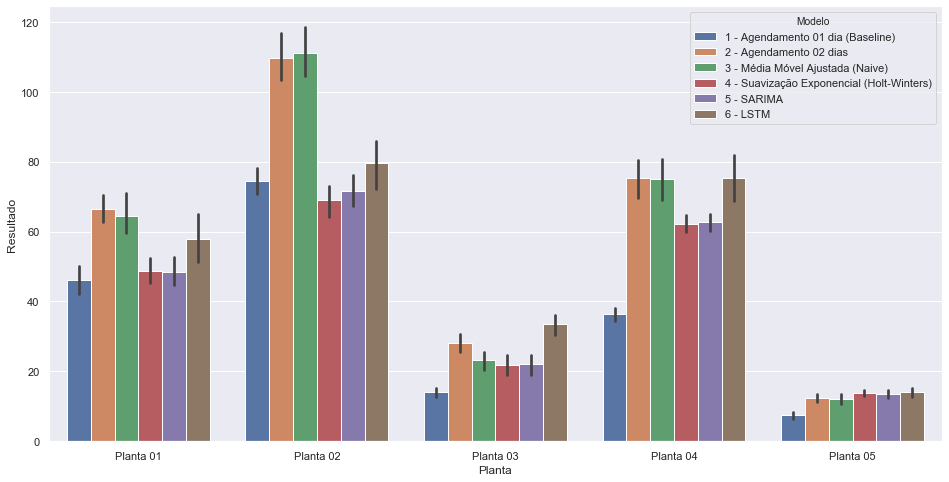

In [137]:
# Resultado Médio e desvio por Modelo por Planta
sns.barplot(x="Planta", y="Resultado", hue="Modelo", data=df_resultado_final)

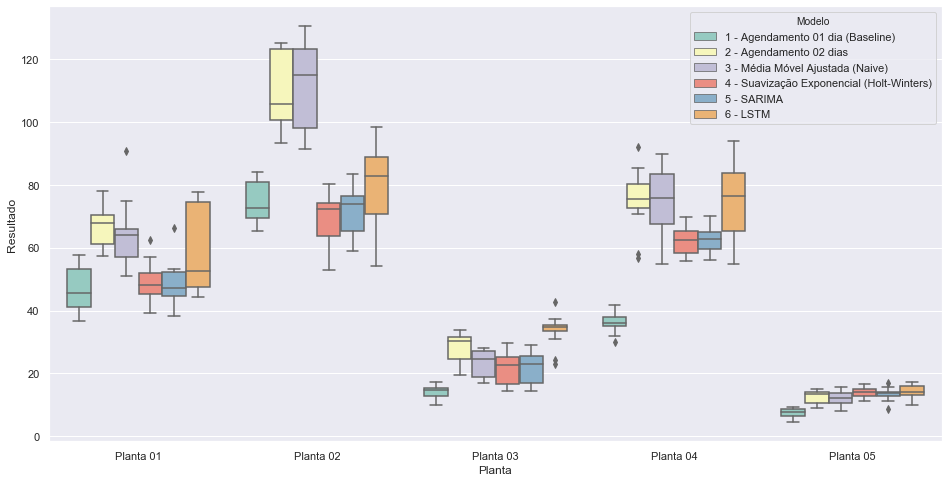

In [139]:
sns.boxplot(x="Planta", y="Resultado", hue="Modelo",
                 data=df_resultado_final, palette="Set3")

In [ ]:
grafico de linha por modelo em cada planta
aumentar tamanho graficos
mover legenda


# 7) Conclusões e Discussão

# 8) Referências

In [39]:
df_lstm["M05 LSTM"] = np.nan

In [40]:
#df_p01.drop(["M05 LSTM"], axis=1, inplace=True)

In [46]:
df_lstm.head()

,Planta,Data,Recebidos,Agendados (01 dia antes),Agendados (02 dias antes),M05 LSTM
0,Planta_01,2019-01-01,0.0,0.0,0.0,NaN
1,Planta_01,2019-01-02,133.0,14.0,14.0,NaN
2,Planta_01,2019-01-03,97.0,61.0,4.0,NaN
3,Planta_01,2019-01-04,106.0,40.0,5.0,NaN
4,Planta_01,2019-01-05,38.0,30.0,4.0,NaN


In [42]:
# Incluir valores da predição no dataframe do modelo
j = 0
for index, row in df_lstm.iterrows():

    if index in range(len(df_lstm_treino["Recebidos"]), len(df_lstm_treino["Recebidos"]) + len(actual_predictions)):
        df_lstm.at[index, "M05 LSTM"] = actual_predictions[j]
        j += 1

In [173]:
# Definição dos Inputs
lista_plantas = ['P1', 'P2', 'P3']
lista_modelo = ['M1', 'M2']
lista_dataset = ['D1', 'D2', 'D3']

In [177]:
import random

df_results = pd.DataFrame({'Modelo' : [], 'Planta' : [], 'Dataset': [], 'Resultado' : []})
    
for x in range(len(lista_modelo)):
    for y in range(len(lista_plantas)):    
        for z in range(len(lista_dataset)):
            df_results = df_results.append({
                'Modelo' : lista_modelo[x], 
                'Planta' : lista_plantas[y],
                'Dataset' : lista_dataset[z],
                'Resultado': random.randint(0, 500)},
                ignore_index=True)

In [188]:
df_results.head()

,Modelo,Planta,Dataset,Resultado
0,M1,P1,D1,302.0
1,M1,P1,D2,66.0
2,M1,P1,D3,281.0
3,M1,P2,D1,158.0
4,M1,P2,D2,339.0


In [51]:
0 – 243
Teste
244 – 257
251 – 264
258 – 271
265 – 278
272 – 285
279 – 292
286 – 299
293 – 306
300 – 313
307 – 320
314 – 327
321 - 334

[]


In [ ]:
# Definição de tamanho dos gráficos

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 25
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

In [ ]:
# Capacidade - 120-150 veículos
plt.title("Vehicle Arrivals per day")
plt.ylabel("Total Arrivals")
plt.xlabel("Days")
plt.grid(True)
plt.autoscale(axis="x", tight=True)
plt.plot(data["Arrivals"])
plt.xticks(np.arange(0, 366, 30))
plt.show()

## Modelo a desenvolver  - Estatístico - ARIMA / SARIMA / SARIMAX (v1 sem esse)

    
Complete guide to ARIMA

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Time%20Series%20Forecastings.ipynb

SARIMAX

https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html

https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/



# Melhor referencia: Jose Portilla

# https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c

## Modelo a desenvolver  - Machine Learning - SVM ou outro


In [7]:

from sklearn.metrics import mean_squared_error
expected = df["Recebidos"]
predictions = df["Planned 6hs before"]
mse = mean_squared_error(expected, predictions)
print('MSE: %f' % mse)

MSE: 771.443451


In [10]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 27.774871


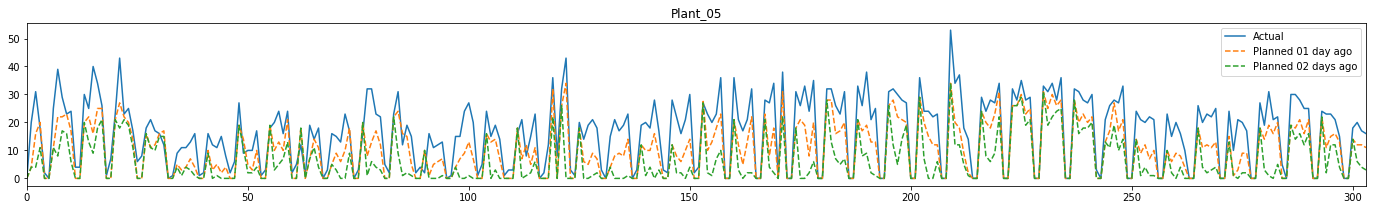

In [16]:
#df_p05.index.name = "Data"
df_p05[['Recebidos', 'Agendados (01 dia antes)', 'Agendados (02 dias antes)']].plot(figsize=(24,3), title="Planta_05", style=["-","--","--"])

In [8]:
# Agregate Data in month, number of week and week day
dados['Data Mês'] = dados['Data'].dt.month
dados['Data Dia'] = dados['Data'].dt.day
dados['Data Dia da semana'] = dados['Data'].dt.weekday 